# Reconstruction of a density matrix

In this tutorial, a walkthrough of how to reconstruct a density matrix via training a pair of modified *Restricted Boltzmann Machines* is presented


## The density matrix to be reconstructed
The density matrix that will be be reconstructed is the density matrix associated with the 2-qubit W state

$$\vert\psi \rangle = \frac{1}{\sqrt{2}}\vert 01\rangle + \frac{1}{\sqrt{2}}\vert10\rangle$$

so that

$$\rho = \vert\psi\rangle\langle\psi\vert$$

with global depolarization probability $p_{dep} = 0.5$ such that

$$\rho_{new} = \left(1 - p_{dep}\right)\rho + \frac{p_{dep}}{2^N} I$$

where $I$ is the identity matrix, representing the maximally mixed state.

The example dataset, `N2_W_state_100_samples_data.txt`, is comprised of 900 $\sigma^z$ measurements, 100 in each of the $3^2$ permutations of two of the bases X, Y and Z. A corresponding file containing the bases for each data point, `N2_W_state_100_samples_bases.txt`, is also required. 

In this tutorial is also included versions with 1000 measurements in each basis, to illustrate the improvements to reconstruction fidelity of a larger data set. The measurements and bases are stored in `N2_W_state_1000_samples_data.txt`, and `N2_W_state_1000_samples_bases.txt` respectively.

The set of all 3^2 bases in which measurements are made is stored in `N2_IC_bases.txt`. Finally, the real and imaginary parts of the matrix are stored in `N2_W_state_target_real.txt` and `N2_W_state_target_imag.txt` respectively. As per convention, spins are represented in binary notation with zero and one denoting spin-up and spin-down, respectively.

## Using QuCumber to reconstruct the density matrix

### Imports
To begin the tutorial, first import the required Python packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch

from qucumber.nn_states import DensityMatrix

from qucumber.callbacks import MetricEvaluator
import qucumber.utils.unitaries as unitaries

import qucumber.utils.training_statistics as ts
import qucumber.utils.data as data
import qucumber

# set random seed on cpu but not gpu, since we won't use gpu for this tutorial
qucumber.set_random_seed(1234, cpu=True, gpu=False)

The Python class `DensityMatrix` contains the properties of an RBM needed to reconstruct the density matrix, as demonstrated in [this paper here].

To instantiate a `DensityMatrix` object, one needs to specify the number of visible, hidden and auxiliary units in the RBM. The number of visible units, `num_visible`, is given by the size of the physical system, i.e. the number of spins or qubits (2 in this case). On the other hand, the number of hidden units, `num_hidden`, can be varied to change the expressiveness of the neural network, and the number of auxiliary units, `num_aux`, can be varied depending on the extent of purification required of the system.

On top of needing the number of visible, hidden and auxiliary units, a `DensityMatrix` object requires the user to input a dictionary containing the unitary operators (2x2) that will be used to rotate the qubits in and out of the computational basis, Z, during the training process. The `unitaries` utility will take care of creating this dictionary.

The `MetricEvaluator` class and `training_statistics` utility are built-in amenities that will allow the user to evaluate the training in real time. 


### Training
To evaluate the training in real time, the fidelity between the true wavefunction of the system and the wavefunction that QuCumber reconstructs, 

$$\operatorname{Tr }\left(\sqrt{\sqrt{\rho_{RBM}}\rho\sqrt{\rho_{RBM}}}\right)$$

will be calculated along with the Kullback-Leibler (KL) divergence (the RBM's cost function). First, the training data and the true wavefunction of this system need to be loaded using the `data` utility.

[this paper here]: https://arxiv.org/pdf/1801.09684.pdf

In [2]:
train_path = "N2_W_state_100_samples_data.txt"
train_bases_path = "N2_W_state_100_samples_bases.txt"
matrix_path_real = "N2_W_state_target_real.txt"
matrix_path_imag = "N2_W_state_target_imag.txt"
bases_path = "N2_IC_bases.txt"


train_samples, true_matrix, train_bases, bases = data.load_data_DM(
    train_path, matrix_path_real, matrix_path_imag, train_bases_path, bases_path
)

The file `N2_IC_bases.txt` contains every unique basis in the `N2_W_state_100_samples_bases.txt` file. Calculation of the full KL divergence in every basis requires the user to specify each unique basis.

As previously mentioned, a `DensityMatrix` object requires a dictionary that contains the unitary operators that will be used to rotate the qubits in and out of the computational basis, Z, during the training process. In the case of the provided dataset, the unitaries required are the well-known $H$, and $K$ gates. The dictionary needed can be created with the following command.

In [3]:
unitary_dict = unitaries.create_dict()
# unitary_dict = unitaries.create_dict(unitary_name=torch.tensor([[real part],
#                                                                 [imaginary part]],
#                                                                 dtype=torch.double)

If the user wishes to add their own unitary operators from their experiment to `unitary_dict`, uncomment the block above. When `unitaries.create_dict()` is called, it will contain the identity and the $H$ and $K$ gates by default under the keys "Z", "X" and "Y", respectively.

The number of visible units in the RBM is equal to the number of qubits. The number of hidden units will also be taken to be the number of visible units.

In [4]:
nv = train_samples.shape[-1]
nh = na = nv

nn_state = DensityMatrix(
    num_visible=nv, num_hidden=nh, num_aux=na, unitary_dict=unitary_dict, gpu=False
)

The number of visible, hidden, and auxiliary units must now be specified. These are given by `nv`, `nh` and `na` respectively. The number of visible units is equal to the size of the system. The hidden and auxiliary units are hyperparameters that must be provided by the user. With these, a `DensityMatrix` object can be instantiated.

Now the hyperparameters of the training process can be specified. 

1. `epochs`: the total number of training cycles that will be performed (default = 100)
2. `pos_batch_size`: the number of data points used in the positive phase of the gradient (default = 100)
3. `neg_batch_size`: the number of data points used in the negative phase of the gradient (default = `pos_batch_size`)
4. `k`: the number of contrastive divergence steps (default = 1)
5. `lr`: coefficient that scales the default value of the (non-constant) learning rate of the Adadelta algorithm (default = 1)

Extra hyperparameters that we will be passing to the learning rate scheduler:
6. `lr_drop_epochs`: the number of epochs after which to decay the learning rate by `lr_drop_factor`
7. `lr_drop_factor`: the factor by which the learning rate drops at `lr_drop_epoch` or all epochs in `lr_drop_epoch` if it is a list

Set `lr_drop_factor` to 1.0 to maintain constant "base" learning rate for Adadelta optimization. The choice shown here is optimized for this tutorial, but can (and should) be varied according to each instance

   **Note:** For more information on the hyperparameters above, it is strongly encouraged that the user to read through the brief, but thorough theory document on RBMs. One does not have to specify these hyperparameters, as their default values will be used without the user overwriting them. It is recommended to keep with the default values until the user has a stronger grasp on what these hyperparameters mean. The quality and the computational efficiency of the training will highly depend on the choice of hyperparameters. As such, playing around with the hyperparameters is almost always necessary. 

In [5]:
epochs = 500
pbs = 100  # pos_batch_size
nbs = pbs  # neg_batch_size
lr = 10
k = 10
lr_drop_epoch = 125
lr_drop_factor = 0.5

For evaluating the training in real time, the `MetricEvaluator` will be called to calculate the training evaluators every `period` epochs. The `MetricEvaluator` requires the following arguments.

1. `period`: the frequency of the training evaluators being calculated (e.g. `period=200` means that the `MetricEvaluator` will compute the desired metrics every 200 epochs)
2. A dictionary of functions you would like to reference to evaluate the training (arguments required for these functions are keyword arguments placed after the dictionary)

The following additional arguments are needed to calculate the fidelity and KL divergence in the `training_statistics` utility.

- `target_matrix` (the true density matrix of the system)
- `space` (the entire Hilbert space of the system)

The training evaluators can be printed out via the `verbose=True` statement.

Although the fidelity and KL divergence are excellent training evaluators, they are not practical to calculate in most cases; the user may not have access to the target wavefunction of the system, nor may generating the Hilbert space of the system be computationally feasible. However, evaluating the training in real time is extremely convenient. 

Any custom function that the user would like to use to evaluate the training can be given to the `MetricEvaluator`, thus avoiding having to calculate fidelity and/or KL divergence. As an example, a function to compute the partition function of the current density matrix is presented. Any custom function given to `MetricEvaluator` must take the neural-network state (in this case, the `Density` object) and keyword arguments. Although the given example requires the Hilbert space to be computed, the scope of the `MetricEvaluator`'s ability to be able to handle any function should still be evident.

In [6]:
def partition(nn_state, space, **kwargs):
    return nn_state.rbm_am.partition(space)

Now the Hilbert space of the system must be generated for the fidelity and KL divergence and the dictionary of functions the user would like to compute every `period` epochs must be given to the `MetricEvaluator`.

In [7]:
period = 25
space = nn_state.generate_hilbert_space()

callbacks = [
    MetricEvaluator(
        period,
        {
            "Fidelity": ts.fidelity,
            "KL": ts.KL,
            # "Partition Function": partition,
        },
        target=true_matrix,
        bases=bases,
        verbose=True,
        space=space,
    )
]

Now the training can begin. The `DensityMatrix` object has a function called `fit` which takes care of this.

In [8]:
nn_state.fit(
    data=train_samples,
    input_bases=train_bases,
    epochs=epochs,
    pos_batch_size=pbs,
    neg_batch_size=nbs,
    lr=lr,
    k=k,
    bases=bases,
    callbacks=callbacks,
    time=True,
    optimizer=torch.optim.Adadelta,
    scheduler=torch.optim.lr_scheduler.StepLR,
    scheduler_args={"step_size": lr_drop_epoch, "gamma": lr_drop_factor},
)

Epoch: 25	Fidelity = 0.863061	KL = 0.050122
Epoch: 50	Fidelity = 0.946054	KL = 0.013152
Epoch: 75	Fidelity = 0.950760	KL = 0.016754
Epoch: 100	Fidelity = 0.957204	KL = 0.015601
Epoch: 125	Fidelity = 0.960522	KL = 0.013925
Epoch: 150	Fidelity = 0.957411	KL = 0.017446
Epoch: 175	Fidelity = 0.961068	KL = 0.013377
Epoch: 200	Fidelity = 0.966589	KL = 0.010754
Epoch: 225	Fidelity = 0.951836	KL = 0.017970
Epoch: 250	Fidelity = 0.960255	KL = 0.012612
Epoch: 275	Fidelity = 0.961232	KL = 0.012477
Epoch: 300	Fidelity = 0.963946	KL = 0.011832
Epoch: 325	Fidelity = 0.959750	KL = 0.013571
Epoch: 350	Fidelity = 0.965108	KL = 0.011095
Epoch: 375	Fidelity = 0.965353	KL = 0.011048
Epoch: 400	Fidelity = 0.963568	KL = 0.011941
Epoch: 425	Fidelity = 0.966334	KL = 0.011148
Epoch: 450	Fidelity = 0.965549	KL = 0.011321
Epoch: 475	Fidelity = 0.965054	KL = 0.011573
Epoch: 500	Fidelity = 0.965568	KL = 0.010963
Total time elapsed during training: 175.240 s


All of these training evaluators can be accessed after the training has completed, as well. The code below shows this, along with plots of each training evaluator versus the training cycle number (epoch).

In [9]:
fidelities = callbacks[0]["Fidelity"]
KLs = callbacks[0]["KL"]
epoch = np.arange(period, epochs + 1, period)

Text(0.5, 0, 'Epoch')

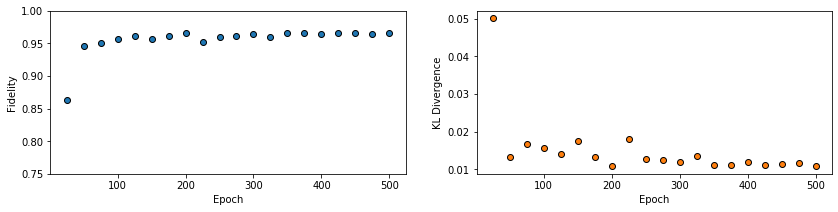

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 3))
ax = axs[0]
ax.plot(epoch, fidelities, "o", color="C0", markeredgecolor="black")
ax.set_ylabel(r"Fidelity")
ax.set_xlabel(r"Epoch")
ax.set_ylim(0.75, 1.00)

ax = axs[1]
ax.plot(epoch, KLs, "o", color="C1", markeredgecolor="black")
ax.set_ylabel(r"KL Divergence")
ax.set_xlabel(r"Epoch")

This saves the weights, and biases of the two internal RBMs as dictionaries containing torch tensors.

In [11]:
nn_state.save("saved_params_W_state.pt")